In [1]:
import numpy as np
import numpy.linalg as LA
np.seterr(all='raise')
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from copy import copy, deepcopy
from itertools import combinations

# 1 Data Preprocessing

## 1.1. tokenizer

In [2]:
from spellchecker import SpellChecker

spell = SpellChecker(language=None, case_sensitive=True)

# Antibiotics
spell.word_frequency.load_words(['acyclovir', 'amikacin', 'amoxicillin', 
'amphotericin_b_deoxycholate', 'ampicillin', 'azithromycin', 'cefaclor', 
'cefazolin', 'cefepime', 'cefixime', 'cefmetazole', 'cefoperazone', 
'ceftazidime', 'ceftibuten', 'ceftriaxone', 'cephradine', 'cilastatin', 
'ciprofloxacin', 'clavulanic_acid', 'clindamycin', 'cobicistat', 
'colistimethate', 'darunavir', 'dicloxacillin_sod', 'doxycycline', 
'emtricitabine', 'entecavir', 'ertapenem_sod', 'erythromycin_estolate', 
'famciclovir', 'flomoxef', 'fluconazole', 'fusidate_sod', 'gemifloxacin', 
'hydroxychloroquine', 'imipenem', 'levofloxacin', 'linezolid', 'meropenem', 
'metronidazole', 'minocycline', 'moxifloxacin', 'moxifloxacin_hydrochloride', 
'norfloxacin', 'nystatin', 'oseltamivir', 'oxacillin_sodium', 'piperacillin',
'po', 'rifampin', 'rilpivirine', 'ritonavir', 'smz_tmp', 'sertaconazole', 
'sulbactam', 'sultamicillin', 'tazobactam', 'teicoplanin', 'tenofovir',
'tenofovir_alafenamide', 'tigecycline', 'triamcinolone_acetonide', 
'trimethoprim', 'unifradine', 'valganciclovir', 'vancomycin'])

# Bacteria
spell.word_frequency.load_words(['achromobacter_denitrificans', 
'acinetobacter_baumannii', 'candida_albicans', 'candida_glabrata', 
'candida_tropicalis', 'citrobacter_koseri', 'corynebacterium_striatum', 
'cyberlindnera_fabianii', 'enterobacter_cloacae_ssp_cloacae', 
'enterococcus_faecalis', 'enterococcus_faecium', 'escherichia_coli', 
'klebsiella_pneumoniae_ssp_ozaenae', 'klebsiella pneumoniae_ssp_pneumoniae', 
'morganella_morganii_ssp_morganii', 'proteus_mirabilis', 'providencia_stuartii',
'pseudomonas_aeruginosa', 'pseudomonas_putida', 'salmonella_group_c1', 
'salmonella_group_d1(non typhi)', 'staphylococcus_aureus', 
'staphylococcus_capitis', 'staphylococcus_caprae', 'staphylococcus_epidermidis',
'staphylococcus_haemolyticus', 'staphylococcus_pettenkoferi', 'yeast_like', 
'klebsiella_pneumoniae_ssp_pneumoniae', 'staphylococcus_aureus_mrsa', 
'salmonella_roup_dnon_typhi', 'enterococcus_faecium_vre'])
# spell.word_frequency.load_text_file('./antibiotics.txt')
# spell.word_frequency.load_text_file('./bacteria.txt')

def tokenizer(s):
    def customized_split(s, token):
        result = []
        for v in s.split(token):
            result.append(v.split(' ')[0])
        return result
     
    if s == 0: return ''
    if isinstance(s, int):
        return str(s)
    
    legal_string = ''
    # Trim illegal marks, numbers, and 'mg'
    for i, ch in enumerate(s):
        # isNumber
        if 48 <= ord(ch) <= 57 or ch in '/()': continue
            
        # mg
        if ch == 'm' and i < len(s)-1:
            if s[i+1] == 'g': continue
        if ch == 'g' and i > 0:
            if s[i-1] == 'm' or 48 <= ord(s[i-1]) <= 57 or s[i-1] == ' ': continue
           
        # split small + large
        if 65 <= ord(ch) <= 90 and i > 0:
            if 97 <= ord(s[i-1]) <= 122: 
                legal_string += ','+ ch.lower()
                continue
                
        # isAlphebet        
        if 97 <= ord(ch.lower()) <= 122:
            legal_string += ch.lower()
        elif ch in (' ', '-'): 
            legal_string += ' '
        else:
            legal_string += ','
    
    # Check spelling
    legal_concepts = []
    for c in legal_string.split(','):
        if c in ('', ' '): continue
            
        concept = '_'.join([x for x in c.split(' ') if x != ''])
        
        if concept in spell:
            legal_concepts.append(concept)
            continue
            
        misspelled = spell.unknown([concept])
        for word in misspelled:
            corrected_word = spell.correction(word)
            if corrected_word in spell: legal_concepts.append(corrected_word)
    
    return ','.join(legal_concepts)

## 1.2 Preprocessing

In [3]:
def preprocessing(info_df, tpr_df, mode, dummies):
    def rename_mapping(df):
        feature_name_mapping = {x: '' for x in df.columns}
        for idx, value in feature_name_mapping.items():
            feature_name_mapping.update({idx: idx.split('_')[-1]})
            if 'antibiotics' in idx:
                feature_name_mapping.update({idx: 'Antibiotics'})
            elif 'Bacteria' in idx:
                feature_name_mapping.update({idx: 'Bacteria'})
            
        return feature_name_mapping
    
    def rename_dummies(df, original_name):
        feature_name_mapping = {x: '' for x in df.columns}
        for idx, value in feature_name_mapping.items():
            feature_name_mapping.update({idx: '_'.join([original_name, idx])})
        return feature_name_mapping
    
    # Rename feature names
    info_df.rename(columns=rename_mapping(info_df), inplace=True)
    tpr_df.rename(columns=rename_mapping(tpr_df), inplace=True)
    
    # Mapping values
    info_df.loc[:,'No']       = info_df.loc[:,'No'].apply(lambda x: str(x)).astype(str).astype('int64') 
    info_df.loc[:,'Bacteria'] = info_df.loc[:,'Bacteria'].fillna(0)
    tpr_df.loc[:,'No']        = tpr_df.loc[:,'No'].apply(lambda x: str(x)).astype(str).astype('int64')
    tpr_df.loc[:,'Time']      = tpr_df.loc[:,'Time'].apply(lambda x: pd.Timestamp(x))
    
    info_df.loc[:,'Comorbidities'] = info_df.loc[:,'Comorbidities'].apply(lambda s: str(s)  if s != 0 else '')
    info_df.loc[:,'Antibiotics']   = info_df.loc[:,'Antibiotics'].apply(tokenizer)
    info_df.loc[:,'Bacteria']      = info_df.loc[:,'Bacteria'].apply(tokenizer)
    
    # Create dummies
    dummy_dfs = []
    if mode == 'train':
        for col in ('Comorbidities', 'Antibiotics', 'Bacteria'):
            dummy_df = info_df[col].str.get_dummies(sep=',')
            # trim those have low frequencies
            dummy_cols = []
            for dummy in dummy_df.columns: 
                if dummy_df[dummy].sum() > 5: 
                    dummy_cols.append(dummy)

            dummies.append(dummy_cols)
            dummy_df = dummy_df[dummy_cols]
            dummy_df.rename(columns=rename_dummies(dummy_df, col), inplace=True)
            dummy_dfs.append(dummy_df)

    elif mode == 'test':
        for i, col in enumerate(('Comorbidities', 'Antibiotics', 'Bacteria')):
            feature_columns = dummies[i]
            n_col = len(feature_columns)
            dummy_df = pd.DataFrame(np.zeros((info_df.shape[0], n_col)), columns=feature_columns)
            for dummy_name in dummy_df.columns:
                dummy_df.loc[:,dummy_name] = info_df.loc[:,col].apply(lambda s: int(dummy_name in s.split(',')))
            dummy_df.rename(columns=rename_dummies(dummy_df, col), inplace=True)
            dummy_dfs.append(dummy_df)

    # Merge dummies
    info_df.drop(['Comorbidities', 'Antibiotics', 'Bacteria'], axis=1, inplace=True)
    info_df = pd.concat([info_df]+dummy_dfs, axis=1)
    
    # Create interaction terms among comorbidities
    info_df['Comorbidities_1:2']   = info_df['Comorbidities_1']*info_df['Comorbidities_2']
    info_df['Comorbidities_1:4']   = info_df['Comorbidities_1']*info_df['Comorbidities_4']
    info_df['Comorbidities_2:4']   = info_df['Comorbidities_2']*info_df['Comorbidities_4']
    info_df['Comorbidities_1:2:4'] = info_df['Comorbidities_1']*info_df['Comorbidities_2']*info_df['Comorbidities_4']
    
    # Imputation
    dfs = []
    for patient_id, patient_df in tpr_df.groupby('No'):
         # last observation carried forward (LOCF)
        dfs.append(patient_df.fillna(method='ffill').fillna(method='bfill'))
    tpr_df = pd.concat(dfs).sort_index()
    
    
    # Combine tabular and time-series data into tabular data
    # Window-based summary
    # generate features: mean/min/max/median/std    
    tpr_df = tpr_df.groupby('No').agg(['mean', 'min', 'max', 'median', 'std'])
    tpr_df.columns = list(map(lambda tup: tup[0]+'_'+tup[1], tpr_df.columns.to_flat_index()))
    
    # Create interaction terms among tpr features (T, P, R, NBPS, NBPD)
    for f1, f2 in combinations(['T', 'P', 'R', 'NBPS', 'NBPD'], 2):
        tpr_df[f1+':'+f2] = tpr_df[f1+'_mean']*tpr_df[f2+'_mean']

    merged_df = pd.merge(info_df, tpr_df, left_on='No', right_index=True)

    return merged_df, dummies

def normalization(df):
    # Normalizaion
    for col in df.columns:
        if col in ('Target', 'No'): continue
        if len(df.loc[:,col].unique()) == 1: continue
        # minmax
        min_value = df.loc[:,col].min()
        max_value = df.loc[:,col].max()
        delta = max_value - min_value
        df.loc[:,col] = df.loc[:,col].apply(lambda x: (x-min_value)/delta)
    return df

def rescaling(train_df, test_df):
    # let the scale of test_df the same as scale of train_df
    df = pd.concat([train_df, test_df])
    rescaled_df = normalization(df)
    n = len(train_df)
    return rescaled_df[:n], rescaled_df[n:].drop({'Target'}, axis=1)

# 2 Feature Selection

In [4]:
from sklearn.feature_selection import f_classif, chi2

class FeatureSelection():
    # --------------------------------------------------------------------------
    def __init__(self):
        self.drop_features = []
    # --------------------------------------------------------------------------
    def fit_transform(self, X_train, y_train):
        drop_features = self.filter_features(X_train.copy(), y_train.copy())
        self.drop_features = drop_features

        return X_train.drop(drop_features, axis=1)
    # --------------------------------------------------------------------------
    def transform(self, X_test):
        # Feature Selection
        return X_test.drop(self.drop_features, axis=1)
    # --------------------------------------------------------------------------
    def filter_features(self, X, Y):
        # reduce redundancy
        drop_features = {col for col in X if len(X[col].unique()) == 1 or col=='No'}
        
        # drop redundant features
        drop_features |= self.redundant(X.drop(drop_features, axis=1), Y)
        
        # feature selected by p-value
        significant_features = self.feature_seletion(X.drop(drop_features, axis=1), Y)

        drop_features.clear()
        drop_features = {col for col in X if col not in significant_features}
        
        return drop_features
    # --------------------------------------------------------------------------
    def feature_seletion(self, X, Y):

        boolean_features   = {col for col in X if len(X[col].unique()) == 2}
        numerical_features = {col for col in X if len(X[col].unique()) > 2}

        X_numerical = X.drop(boolean_features, axis=1)
        X_boolean   = X.drop(numerical_features, axis=1)
        
        pvalue_numerical = f_classif(X_numerical, Y)[1]
        pvalue_boolean   = chi2(X_boolean, Y)[1]
            
        selected_features = set()
        for i, col in enumerate(X_numerical.columns):
            if pvalue_numerical[i] < 0.05: 
                selected_features |= {col}
        for i, col in enumerate(X_boolean.columns):
            if pvalue_boolean[i] < 0.05: 
                selected_features |= {col}
        individual_features = set() 
        for f in selected_features:
            # check interactions
            if ':' not in f: continue
            if 'Comorbidities_' in f:
                terms = f.split('Comorbidities_')[1].split(':')
                individual_features |= {'Comorbidities_'+i for i in terms}
            else:
                terms = f.split(':')
                individual_features |= {i+'_mean' for i in terms}
        selected_features |= individual_features

        return selected_features
    # --------------------------------------------------------------------------
    def redundant(self, X, Y):
        corr_matrix = X.corr()
        n = corr_matrix.shape[0]
        redundant_feature_groups = []
        for (i, j) in combinations(range(n),2):
            if abs(corr_matrix.iloc[i,j]) < 0.95: continue
            if not redundant_feature_groups: 
                redundant_feature_groups.append([i, j])
                continue

            add = False
            for group in redundant_feature_groups:
                if i in group and j in group: 
                    add = True
                    break
                elif i in group:
                    group.append(j)
                    add = True
                    break
                elif j in group:
                    group.append(i)
                    add = True
                    break

            if not add:
                redundant_feature_groups.append([i, j])
                
        redundant_features = set()
        for group in redundant_feature_groups:
            correlations = np.zeros((len(group),))
            for i, _id in enumerate(group):
                correlations[i] = X.iloc[:,_id].corr(Y)
            for i in np.argsort(correlations)[:-1]:
                redundant_features.add(X.columns[group[i]])
                
        return redundant_features

# 3 Model

## 3.1 Logistic Model

In [5]:
class LogisticRegression():
    # --------------------------------------------------------------------------
    def __init__(self, lambda_=1, max_iter=100, eta=1e-2, solver='simple_GD'):
        self.lambda_ = lambda_ # regularization term
        self.max_iter = max_iter
        self.eta = eta
        self.solver = solver
        self.weight = []
        self.X = []
        self.y = []
        self.features = []
    # --------------------------------------------------------------------------
    def logit(self, x):
        return .5 * (1 + np.tanh(.5 * x))
    # --------------------------------------------------------------------------
    def fit(self, X, y):
        self.features = X.columns
        self.X = np.hstack((np.ones((X.shape[0],1)),X)).copy() # X_[:,0] = [1, ..., 1]
        self.y = y.copy()
        
        score = np.zeros((20,))
        ws = np.zeros((20, self.X.shape[1]))

        for i in range(20):
            w = np.random.rand(self.X.shape[1], )
            if self.solver == 'simple_GD':
                w = self.simple_GD(w)
            elif self.solver == 'momentum_GD':
                w = self.momentum_GD(w)
#             elif self.solver == 'BFGS':
#                 w = self.BFGS(w)
            score[i] = self.f(w)
            ws[i] = w
        self.weight = ws[np.argmax(score)]
        
        return self.weight
    # --------------------------------------------------------------------------
    def f(self, w):
        X = self.X
        y = self.y # (N,)
        sigmoid = self.logit(X.dot(w))
        return np.sum(y*np.log(sigmoid) + (1-y)*np.log(1-sigmoid)) - self.lambda_*w.dot(w)
    # --------------------------------------------------------------------------
    def f_diff(self, w):
        '''
        input w
        Output (P,)
        '''
        X = self.X # (320,80)
        y = self.y # (320,)
        sigmoid = self.logit(X.dot(w)) 
        gradient = X.T.dot(y-sigmoid) - 2*self.lambda_*w
        return gradient
    # --------------------------------------------------------------------------
    def simple_GD(self, w0):
        w = w0.copy()
        for iter in range(self.max_iter):
            gradient = self.f_diff(w)
            w_new = w + self.eta*gradient
            
            if LA.norm(w_new - w) < 1e-6:
                return w_new
            w = w_new
        return w
    # --------------------------------------------------------------------------
    def momentum_GD(self, w0):
        w = w0.copy()
        momentum = np.zeros(w.shape)
        for iter in range(self.max_iter):
            gradient = self.f_diff(w)
            momentum_new = 0.1*self.eta*gradient + 0.9 * momentum
            w_new = w + momentum_new
            
            # Check converge
            if LA.norm(w_new - w) < 1e-6:
                return w_new
            
            momentum = momentum_new
            w = w_new
        return w
    # --------------------------------------------------------------------------
    def predict(self, X):
        X_ = np.hstack((np.ones((X.shape[0],1)),X))
        y = self.logit(X_.dot(self.weight))
        y[y > 0.5] = 1
        y[y <= 0.5] = 0
        return y
    # --------------------------------------------------------------------------
    def predict_probability(self, X):
        X_ = np.hstack((np.ones((X.shape[0],1)),X))
        prob  = self.logit(X_.dot(self.weight))
        return prob
    # --------------------------------------------------------------------------
    def visualize(self):
        weights = self.weight[1:]
        colors = ['indianred' if w > 0  else 'forestgreen' for w in weights]
        features = self.features
        y_pos = np.arange(len(features))
        
        fig, ax = plt.subplots(figsize=(8,6))
        ax.barh(y_pos, weights, color=colors)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(features)
        ax.invert_yaxis()  # labels read top-to-bottom
        ax.set_title('FeatureWeights')

        fig.patch.set_visible(False)
        fig.tight_layout()
        plt.show()

## 3.2 Ensemble

In [6]:
class BaggingClassifier():
    # --------------------------------------------------------------------------
    def __init__(self, base_models, n_estimators):
        self.base_models = base_models
        self.n_estimators = n_estimators
        self.n_models = int(len(base_models)*(n_estimators+1))
        self.models = []
    # --------------------------------------------------------------------------
    def fit(self, X, y):
        # Model Generation
        models = []
        for base_model in self.base_models:
            for i in range(self.n_estimators):
                sampled_indices = np.random.choice(X.shape[0], X.shape[0])

                X_ = X.iloc[sampled_indices, :]
                y_ = y.iloc[sampled_indices]

                # Train model on Tr_ and store it
                model = deepcopy(base_model)
                model.fit(X_, y_)
                models.append(model)
            model = deepcopy(base_model)
            model.fit(X, y)
            models.append(model)
            
        self.models = models
    # --------------------------------------------------------------------------
    def predict(self, X, method):
        if method == 'majority_vote':
            # Predict by Voting
            Y = np.zeros((self.n_models, X.shape[0]))
            for i, model in enumerate(self.models):
                Y[i] = model.predict(X)

            # Majority Vote
            y = Y.mean(axis=0)
            y[y > 0.5] = 1
            y[y <= 0.5] = 0
            
        elif method == 'probability':
            # Predict by accumulation
            prob = np.zeros((self.n_models, X.shape[0]))
            for i, model in enumerate(self.models):
                prob[i] = model.predict_probability(X)

            # Take average on probability
            y = prob.mean(axis=0)
            y[y > 0.5] = 1
            y[y <= 0.5] = 0
        
        return y

In [7]:
def cross_validation(df, kfold:int):
    
    # split X, Y
    X = df.drop('Target', axis=1)
    y = df.loc[:,'Target']
    
    # Stratified K fold
    kf = StratifiedKFold(n_splits=kfold, shuffle=True)
    kf.get_n_splits(X)
    
    param = {'lambda_': [0, 1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3]}
    validated_table = pd.DataFrame(np.zeros((8,8)), columns=['lambda_', 'f1_score_0', 'f1_score_1', 
                                                             'f1_score_2', 'f1_score_3', 'f1_score_4', 
                                                             'mean', 'std'])
    j = 0
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Feature Selection
        selector = FeatureSelection()
        X_train = selector.fit_transform(X_train.copy(), y_train.copy())
        X_test = selector.transform(X_test.copy())
        
        # Training Models and Record F1 scores
        ## Loop over different models with different lambda (penalty)
        models = []
        for i, lambda_ in enumerate(param['lambda_']):
            model    = LogisticRegression(lambda_=lambda_, max_iter=200, eta=1e-2, solver='momentum_GD')
            ensemble = BaggingClassifier([model], n_estimators=10)
            ensemble.fit(X_train.copy(), y_train.copy())

            prediction     = ensemble.predict(X_test.copy(), method='majority_vote')
            tn, fp, fn, tp = confusion_matrix(y_test.to_numpy().flatten(), prediction).ravel()

            validated_table.loc[i, 'lambda_'] = lambda_
            validated_table.loc[i, 'f1_score_'+str(j)] = 2*tp/(2*tp+fp+fn)

            if 1e-3 <= lambda_ <= 1e-2:
                models.append(model)

        ensemble = BaggingClassifier(models, n_estimators=10)
        ensemble.fit(X_train.copy(), y_train.copy())

        prediction = ensemble.predict(X_test.copy(), method='majority_vote')
        tn, fp, fn, tp = confusion_matrix(y_test.to_numpy().flatten(), prediction).ravel()
        validated_table.loc[i+1, 'lambda_'] = 'ensemble'
        validated_table.loc[i+1, 'f1_score_'+str(j)] = 2*tp/(2*tp+fp+fn)
        
        j += 1 
        
    validated_table.loc[:, 'mean'] = validated_table.iloc[:, 1:6].mean(axis=1)
    validated_table.loc[:, 'std']  = validated_table.iloc[:, 1:6].std(axis=1)
    
    return validated_table

## Main - Training & Cross Validation

In [8]:
Info_train_df = pd.read_excel('Training data.xlsx', sheet_name=0)
TPR_train_df  = pd.read_excel('Training data.xlsx', sheet_name=1) 
dummies = []
train_df, dummies = preprocessing(deepcopy(Info_train_df), deepcopy(TPR_train_df), 'train', dummies)

In [9]:
Tr = normalization(train_df.copy())

In [10]:
kfold = 5
table = cross_validation(Tr, kfold)

In [11]:
table # max_iter: 200, eta: 1e-2, n_estimator: 10

,lambda_,f1_score_0,f1_score_1,f1_score_2,f1_score_3,f1_score_4,mean,std
0,0,0.538462,0.500000,0.600000,0.615385,0.615385,0.573846,0.052058
1,1,0.454545,0.200000,0.363636,0.400000,0.545455,0.392727,0.127662
2,0.1,0.518519,0.500000,0.620690,0.615385,0.615385,0.573995,0.059497
3,0.05,0.592593,0.466667,0.600000,0.560000,0.560000,0.555852,0.053121
4,0.01,0.538462,0.518519,0.625000,0.714286,0.583333,0.595920,0.077953
5,0.005,0.538462,0.518519,0.580645,0.666667,0.615385,0.583935,0.059564
6,0.001,0.538462,0.500000,0.562500,0.666667,0.615385,0.576603,0.065454
7,ensemble,0.538462,0.482759,0.600000,0.714286,0.640000,0.595101,0.089546


## Main - Testing (Prediction)

In [12]:
Info_test_df = pd.read_excel('Testing data.xlsx', sheet_name=0)
TPR_test_df  = pd.read_excel('Testing data.xlsx', sheet_name=1) 
test_df, dummies = preprocessing(deepcopy(Info_test_df), deepcopy(TPR_test_df), 'test', dummies)
Tr, Ts = rescaling(train_df.copy(), test_df.copy())

In [22]:
# split X, Y
X_train = Tr.drop('Target', axis=1)
y_train = Tr.loc[:,'Target']

param = {'lambda_': [0, 1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3]}
models = []
# Feature Selection
selector = FeatureSelection()
X_train = selector.fit_transform(X_train.copy(), y_train.copy())
X_test = selector.transform(Ts.copy())

for i, lambda_ in enumerate(param['lambda_']):
    model = LogisticRegression(lambda_=lambda_, max_iter=200, eta=1e-2, solver='momentum_GD')
    model.fit(X_train.copy(), y_train.copy())
    models.append(model)

ensemble = BaggingClassifier(models[4:], n_estimators=10)
ensemble.fit(X_train.copy(), y_train.copy())

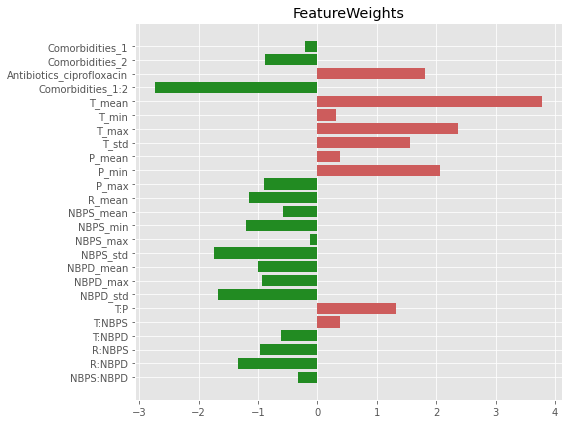

In [23]:
models[0].visualize() # lambda_=0

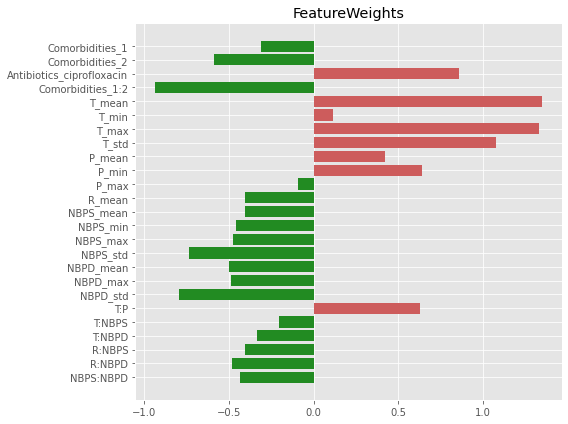

In [24]:
models[1].visualize() # lambda=1

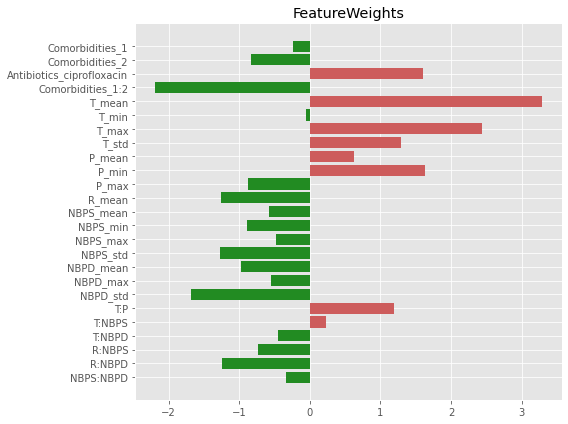

In [25]:
models[2].visualize() # lambda_=1e-1

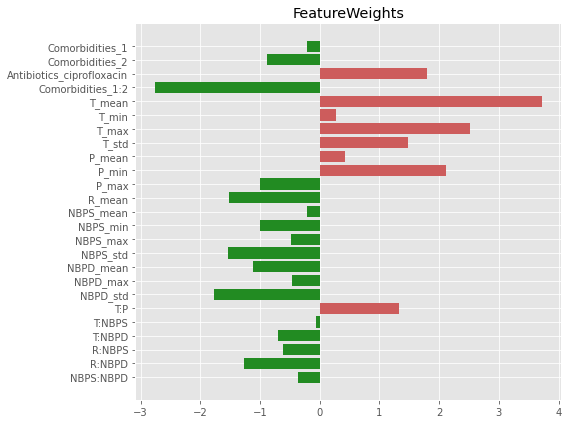

In [26]:
models[4].visualize() # lambda=1e-2

In [31]:
prediction = ensemble.predict(X_test.copy(), method='majority_vote')

In [32]:
# Write file
submission = pd.read_csv('0856617.csv')
for i in range(len(submission)):
    submission.loc[i, 'Target'] = prediction[i]
submission = submission.astype('int32')
submission.to_csv('0856617.csv', index=False)

### Function Testing

In [34]:
models[0].predict(X_test.copy())

array([0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.])

In [33]:
models[0].predict_probability(X_test.copy())

array([0.05311536, 0.11737974, 0.37270211, 0.07698315, 0.49575565,
       0.0066607 , 0.21329123, 0.55254732, 0.7622379 , 0.16533949,
       0.02533129, 0.30345518, 0.02515972, 0.63130452, 0.14123054,
       0.06222647, 0.30192812, 0.08367699, 0.87603028, 0.42266799,
       0.0093339 , 0.90140672, 0.28323219, 0.09471273, 0.27651275,
       0.84375275, 0.07254734, 0.08113814, 0.05209174, 0.23262378,
       0.11430519, 0.27192444, 0.21926891, 0.22598407, 0.15916993,
       0.18278782, 0.44350138, 0.05830152, 0.03049071, 0.36555837,
       0.08418049, 0.12845454, 0.43065129, 0.51129414, 0.11859774,
       0.83252174, 0.30986011, 0.17118555, 0.02406062, 0.1479569 ,
       0.05790583, 0.00197543, 0.67931741, 0.16918345, 0.02637849,
       0.21819888, 0.92059703, 0.12899064, 0.06105769, 0.05432696,
       0.39224587, 0.10961899, 0.13731909, 0.80926622, 0.03977129,
       0.19398057, 0.00260569, 0.74873806, 0.21512289, 0.20182887,
       0.11239804, 0.24887347, 0.24346303, 0.65653906, 0.00161

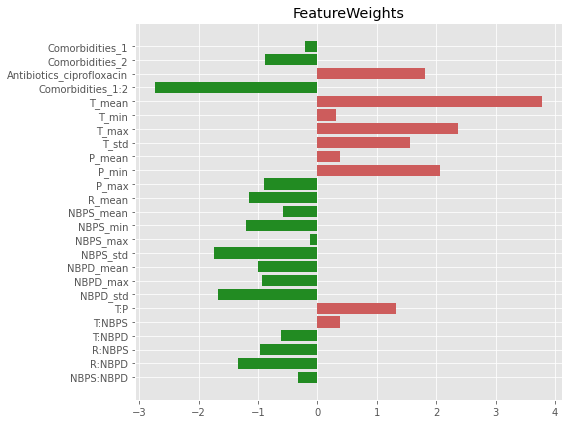

In [36]:
models[0].visualize()